In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize 
import datetime
from matplotlib.dates import DateFormatter
import time

In [3]:
# Loads historical funding data and optionally calculates cumulative return.
# start_datetime and end_datetime are datetime objects
def get_funding_data(ticker, start_datetime, end_datetime, calc_return=True):
    url = 'https://www.bitmex.com/api/v1/funding'
    params = {
            "count" : 500,
            "filter": '{"symbol": "%s"}' % ticker,
            "columns": '["fundingRate", "symbol", "timestamp"]'
    }
    
    last_timestamp = start_datetime
    pause = .5
    funding_data = None

    while last_timestamp < end_datetime:
        params['startTime'] = str(start_datetime)
        print("Pulling data with start date " + str(start_datetime))
        new_data = json_normalize(requests.get(url, params).json())
        if not new_data.empty and new_data.shape[0] > 1:
            new_data['timestamp'] = new_data['timestamp'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ"))
            new_data.sort_values(by='timestamp', ascending=True, inplace=True)
            last_timestamp = new_data.tail(1).timestamp.iloc[0]
            if funding_data is None:
                funding_data = new_data
            else:
                funding_data = funding_data.append(new_data)
        else:
            break
        print("Loaded " + str(new_data.shape[0]) + " data points")
        start_datetime = last_timestamp
        # Don't want to get rate limited
        time.sleep(pause)
    
    if calc_return:
        funding_data['return'] = (1 + funding_data['fundingRate']).cumprod()
        
    funding_data.reset_index(inplace=True)
    del funding_data['index']
    funding_data.index = funding_data['timestamp']
        
    return funding_data


Pulling data with start date 2018-01-01 00:00:00
Loaded 500 data points
Pulling data with start date 2018-06-16 12:00:00
Loaded 500 data points
Pulling data with start date 2018-11-29 20:00:00
Loaded 500 data points
Pulling data with start date 2019-05-15 04:00:00
Loaded 359 data points
Pulling data with start date 2019-09-11 12:00:00


fundingRate               -0.00375
symbol                      XBTUSD
timestamp      2018-01-01 04:00:00
return                    0.870268
dtype: object

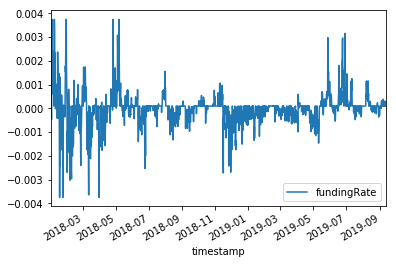

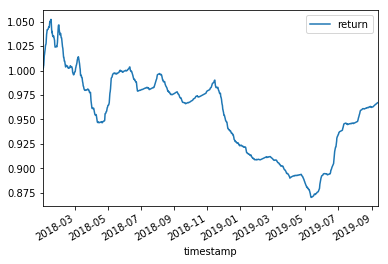

In [4]:
ticker = "XBTUSD"
start_datetime = datetime.datetime(year=2018, month=1, day=1)
end_datetime = datetime.datetime(year=2020, month=1, day=1)

funding_data = get_funding_data(ticker, start_datetime, end_datetime)
funding_data.plot(y=['fundingRate'])
funding_data.plot(y=['return'])

funding_data.min()

In [ ]:
## Original code

In [ ]:
# Insert either XBTUSD or ETHUSD for Ticker
# I need to pull the first pass -- go to the end of the data -- pull that date -- use that as end date
def get_funding_rate_helper(ticker, start_date, end_date):
    
    # URL Construction 
    url = 'https://www.bitmex.com/api/v1/funding'
    
    # Specific Parameters to pass to URL
    params = {
            "count" : 500,
            "reverse":"True",
            "startTime": start_date,
            "endTime": end_date,
            "filter": '{"symbol": "%s"}' % ticker,
            "columns": '["fundingRate", "symbol", "timestamp"]'
    }
    
    
    data = json_normalize(requests.get(url, params).json())
    data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ"))
    data.sort_values(by='timestamp', ascending=True, inplace=True)
    return data

def total_funding_rate_return(ticker, start_date, end_date):
    data = get_funding_data(ticker, start_date, end_date)
    data['return'] = (1 + data['fundingRate']).cumprod() 
    return data

In [ ]:
import matplotlib.dates as mdates

ticker = "XBTUSD"
start_datetime = datetime.datetime(year=2018, day=1, month=1)
end_datetime = datetime.datetime(year=2019, day=1, month=1)
funding_data = get_funding_data(ticker, start_datetime, end_datetime)

months = mdates.MonthLocator()
fig, ax = plt.subplots()
ax.plot('timestamp', 'return', data=funding_data)

## Setting the axis formats
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(months)

##
title = 'Yield on Shorting {} 1 to 1 on BitMEX Based on Funding Rate'.format(ticker)
ax.set_title(title, pad=20)
ax.set_ylabel("Return on $1")
ax.set_xlabel("Date")